In [1]:
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from icecream import ic
from pathlib import Path
import time
import os
import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
print("***** Put the interpreter in UTC, to make sure no TZ issues")
os.environ["TZ"] = "UTC"
time.tzset()

***** Put the interpreter in UTC, to make sure no TZ issues


In [4]:
import sys
sys.path.append("../../../..")
import ascat

# Start with importing the data from WHOI

## Use the code in https://github.com/jerabaul29/MachineOcean_WP1_WHOI

In [5]:
import sys
sys.path.append("../../MachineOcean_WP1_WHOI/")

In [6]:
import mo_whoi_data

In [7]:
from mo_whoi_data.load_data import load_data_xarray
from mo_whoi_data.residual_learning_time_hist.predictors import predictors

***** Put the interpreter in UTC, to make sure no TZ issues


See Jean's code:

https://github.com/jerabaul29/MachineOcean_WP1_WHOI/blob/main/mo_whoi_data/residual_learning_time_hist/0_prepare_ml_data.ipynb

In [8]:
dict_all_Transfer_files = load_data_xarray.load_all_into_xarray(run_on_ppi=True)

all_filenames: [PosixPath('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_Endurance_7.mat'),
                PosixPath('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_SPURS1.mat'),
                PosixPath('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_Endurance_3.mat'),
                PosixPath('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_Pioneer_6.mat'),
                PosixPath('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_Endurance_8.mat'),
                PosixPath('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_Pioneer_8.mat'),
                PosixPath('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_Irminger_3.mat'),
                

In [9]:
# for each of the data files, have a datetime that is rounded to the nearest minute
# this is needed because as of now, converted from matlab datetime, which is a float and has rounding errors...


def round_np_datetime64(np_datetime64):
    rounding_offset = np.timedelta64(30, 'm')
    to_round = np_datetime64 + rounding_offset
    rounded = to_round.astype('datetime64[h]')
    return rounded


for crrt_dataset in dict_all_Transfer_files:
    crrt_pd = dict_all_Transfer_files[crrt_dataset]
    datetimes = crrt_pd["datetime"]
    rounded_datetimes = round_np_datetime64(datetimes)
    crrt_pd["datetime_rounded"] = rounded_datetimes

# for crrt_dataset in dict_all_Transfer_files:
#     ic(crrt_dataset)
#     crrt_pd = dict_all_Transfer_files[crrt_dataset]
# 
#     # sanity check: we have not messed things up, we typically have a jump of either 1 hour, or more than 1.5 hours
#     jump_in_datetimes_rounded = (crrt_pd["datetime_rounded"][1:].to_numpy() - crrt_pd["datetime_rounded"][0:-1].to_numpy()) / np.timedelta64(1, 's')
#     ic(jump_in_datetimes_rounded)
#     deviation_from_1hr_jumps = jump_in_datetimes_rounded - 3600
#     ic(deviation_from_1hr_jumps)
#     time_jump_problems = np.where(
#         np.logical_and(
#             np.abs(deviation_from_1hr_jumps) > 0.01,
#             np.abs(deviation_from_1hr_jumps) < 7600,
#         )
#     )
#     ic(time_jump_problems)

In [10]:
# make all predictors real...
# some of the predictors were not real in some of the input datasets...
# - check that the imaginary part is less than 1e-3
# - convert to real keeping only the real part

# for spot check
#ic(dict_all_Transfer_files[Path("/home/jrmet/Desktop/Data/MachineOcean/WP1/WHOI/Transfer_SouthernOcean2.mat")]["U10e"])

for crrt_dataset in dict_all_Transfer_files:
    #ic(crrt_dataset)

    crrt_pd = dict_all_Transfer_files[crrt_dataset]

    for crrt_row in predictors:
        crrt_dtype = crrt_pd[crrt_row].to_numpy().dtype

        # find out which dtypes are not <f8
        if crrt_dtype != np.dtype('<f8'):
            #ic(crrt_row)
            #ic(crrt_dtype)

            # check that all imaginary parts are close to 0 at precision 1e-4
            # NOTE: some entries are imaginary
            if not np.all(np.abs(np.imag(crrt_pd[crrt_row].to_numpy())) < 1e-3):
                raise RuntimeError("Some non small imaginary parts!")
            # extract the real part
            real_part = np.real(crrt_pd[crrt_row].to_numpy())
            # overwrite the row with the float one
            crrt_pd[crrt_row] = real_part

# spot check
#ic(dict_all_Transfer_files[Path("/home/jrmet/Desktop/Data/MachineOcean/WP1/WHOI/Transfer_SouthernOcean2.mat")]["U10e"])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3324/3324 [00:02<00:00, 1276.70it/s]


2580 (3324,)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9130/9130 [00:06<00:00, 1363.66it/s]


6670 (9130,)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2994/2994 [00:02<00:00, 1459.40it/s]


2145 (2994,)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5727/5727 [00:04<00:00, 1259.70it/s]


4816 (5727,)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1609/1609 [00:01<00:00, 1356.96it/s]


1263 (1609,)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3568/3568 [00:03<00:00, 1182.05it/s]


3100 (3568,)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5621/5621 [00:04<00:00, 1225.50it/s]


4663 (5621,)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6552/6552 [00:02<00:00, 2405.29it/s]


2611 (6552,)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8724/8724 [00:05<00:00, 1679.75it/s]


5204 (8724,)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3573/3573 [00:02<00:00, 1496.73it/s]


2479 (3573,)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3934/3934 [00:02<00:00, 1340.55it/s]


3066 (3934,)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:02<00:00, 1361.42it/s]


2660 (3465,)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2515/2515 [00:01<00:00, 1383.58it/s]


1839 (2515,)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9905/9905 [00:08<00:00, 1211.78it/s]


8587 (9905,)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8193/8193 [00:06<00:00, 1323.03it/s]


6322 (8193,)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1109/1109 [00:00<00:00, 1354.55it/s]


856 (1109,)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3829/3829 [00:01<00:00, 2346.46it/s]


1641 (3829,)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2937/2937 [00:02<00:00, 1259.85it/s]


2416 (2937,)


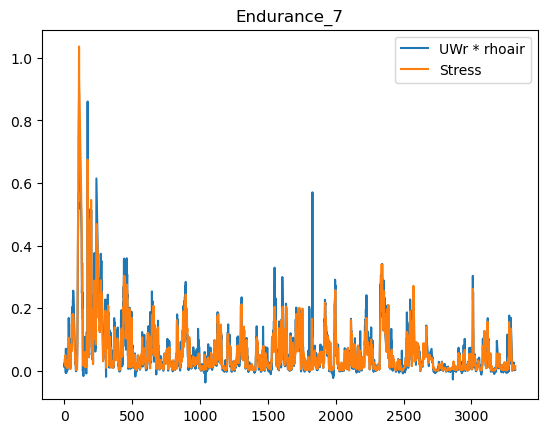

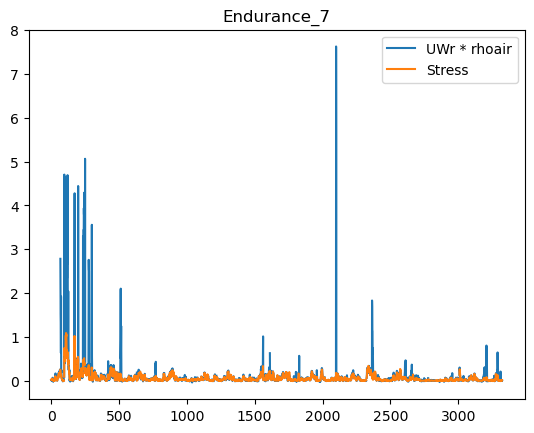

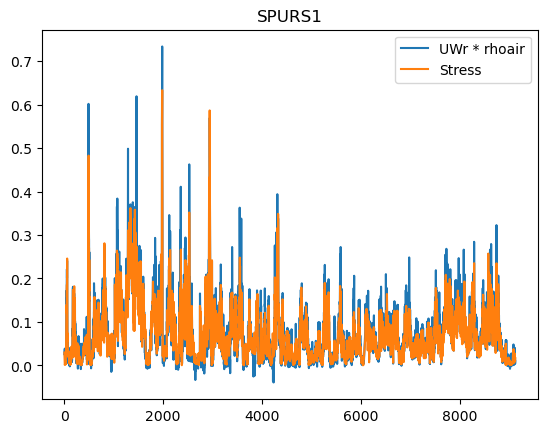

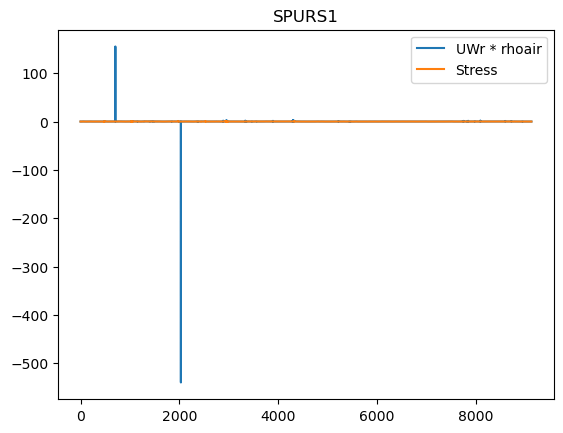

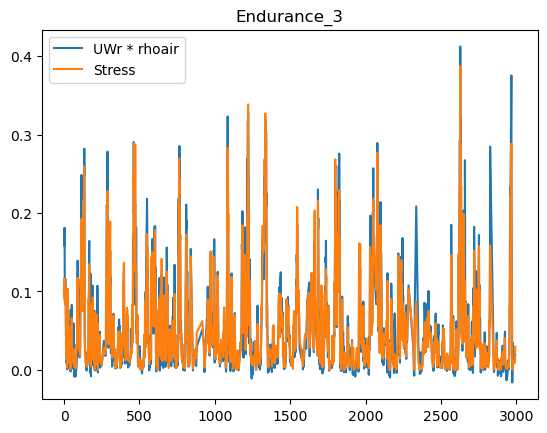

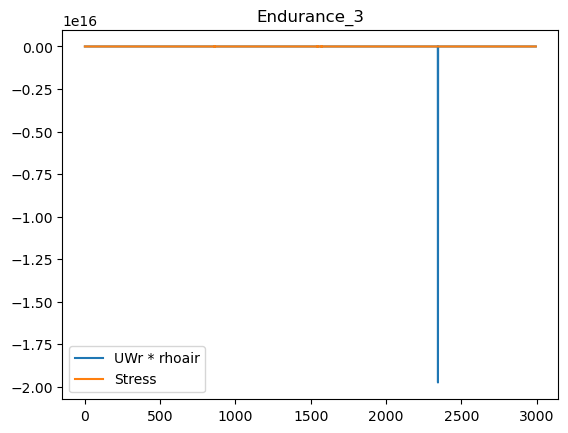

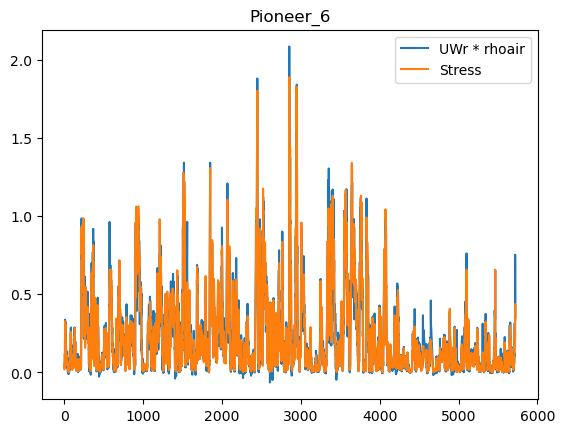

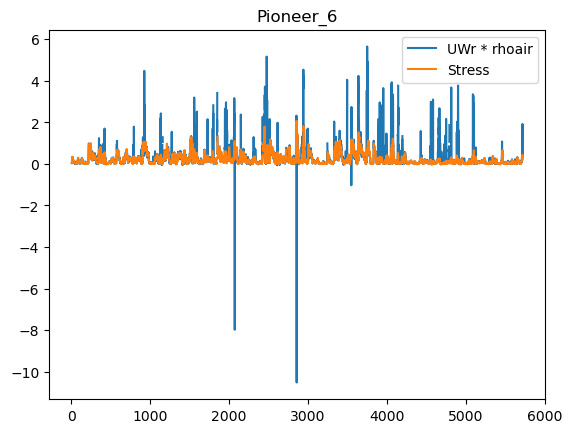

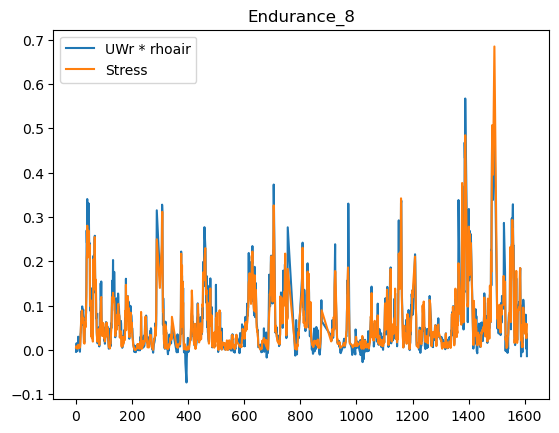

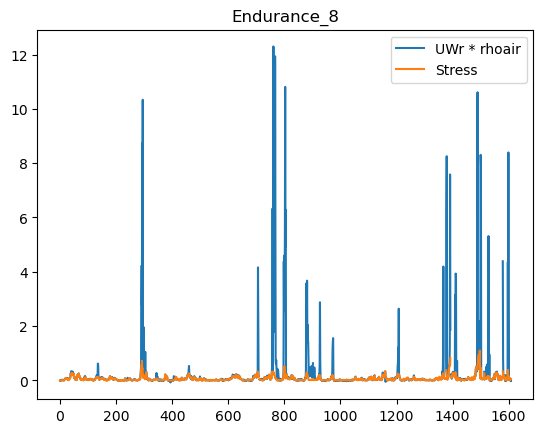

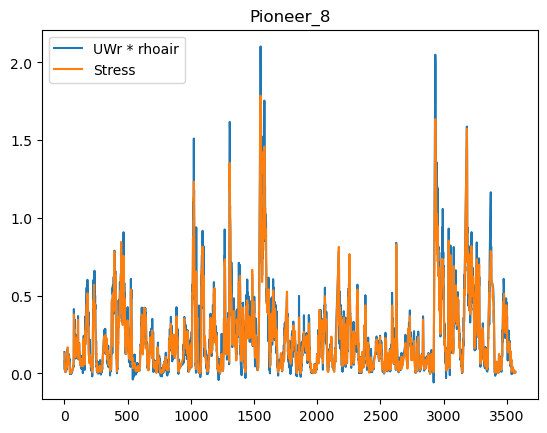

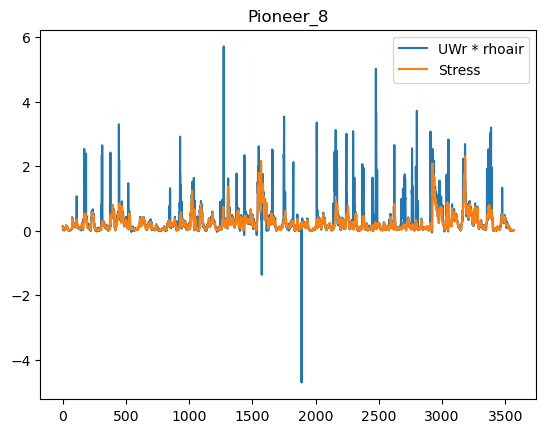

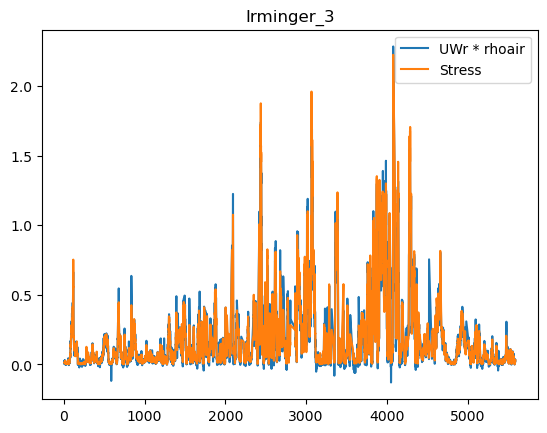

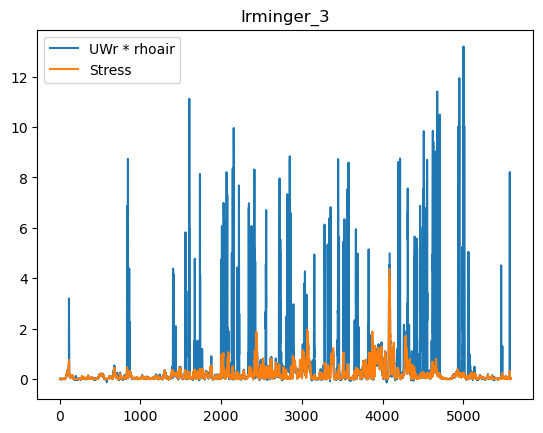

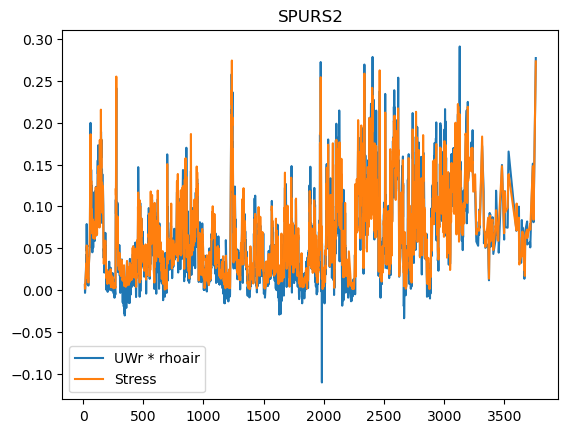

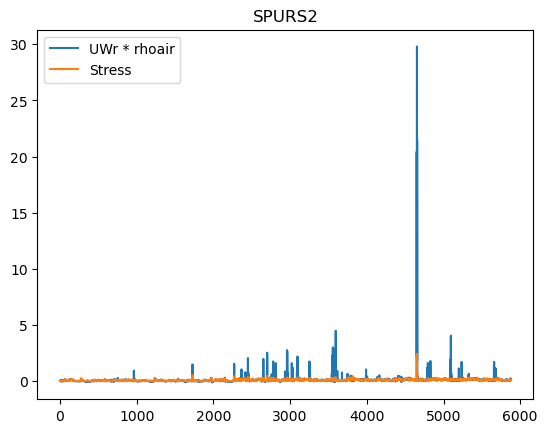

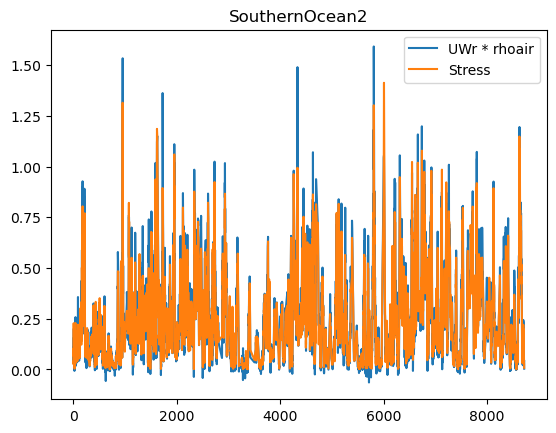

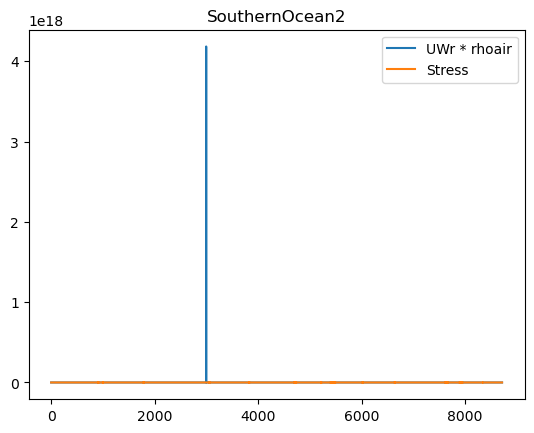

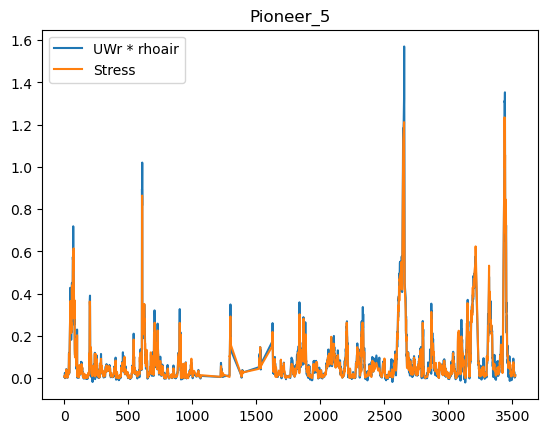

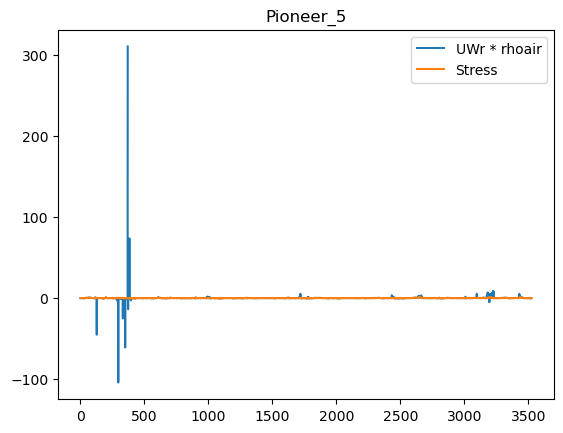

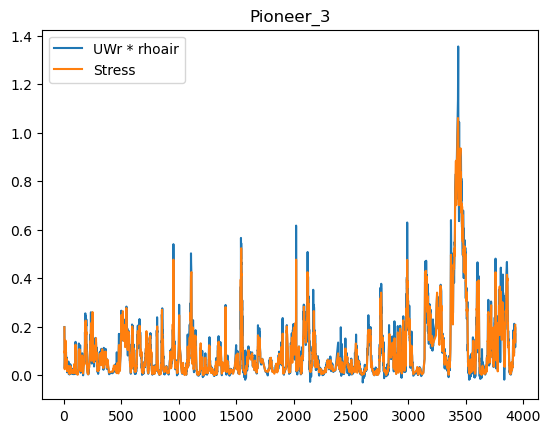

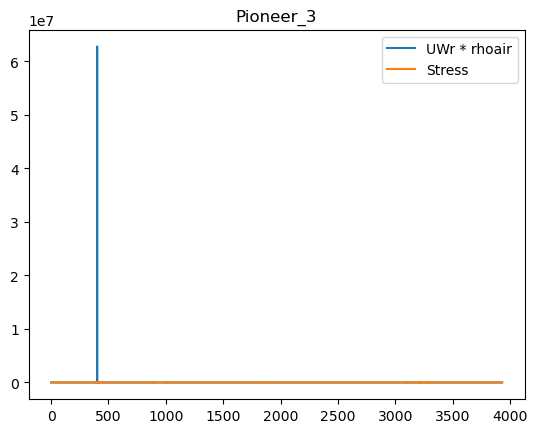

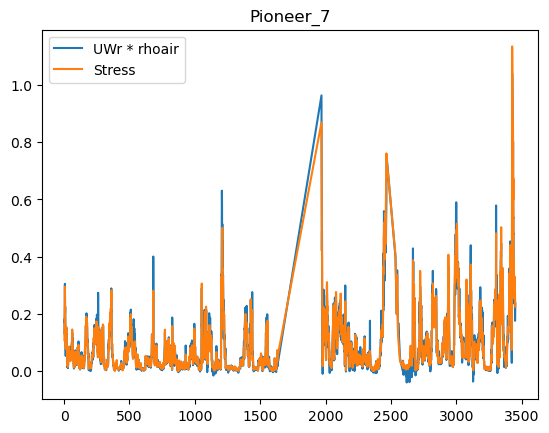

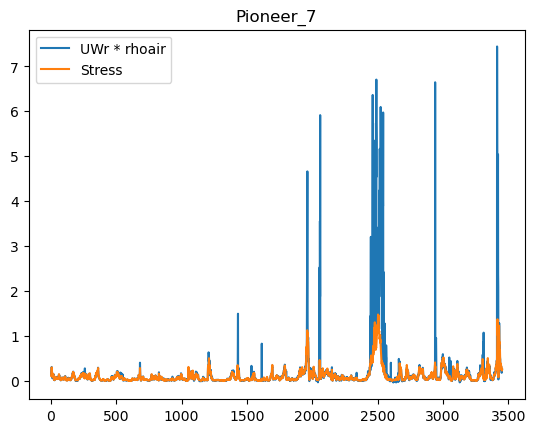

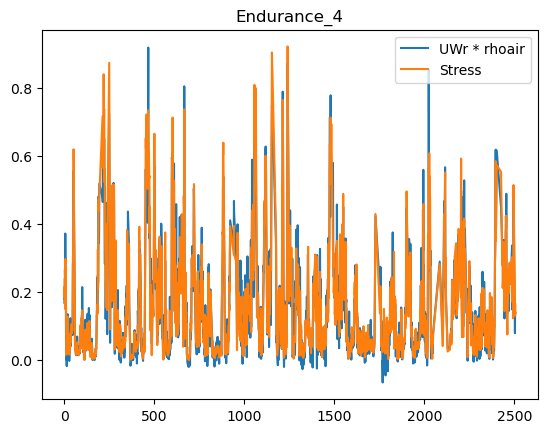

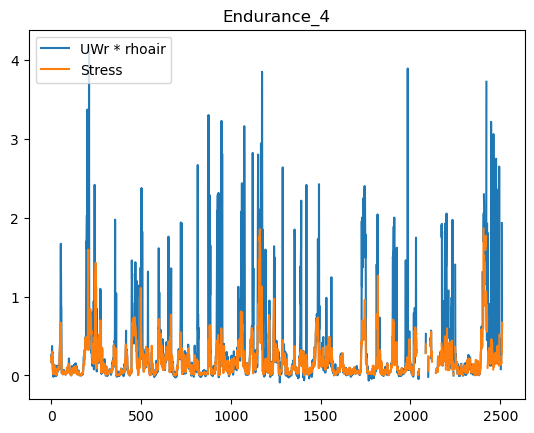

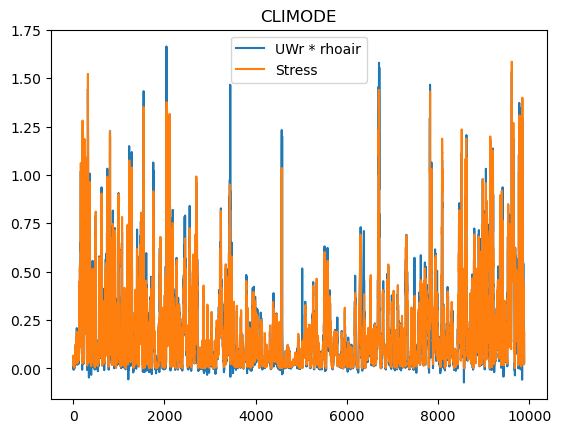

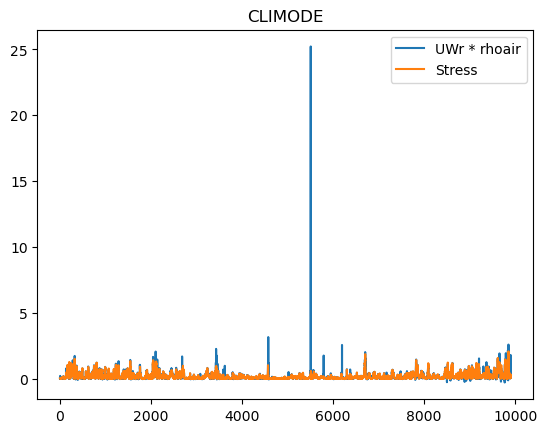

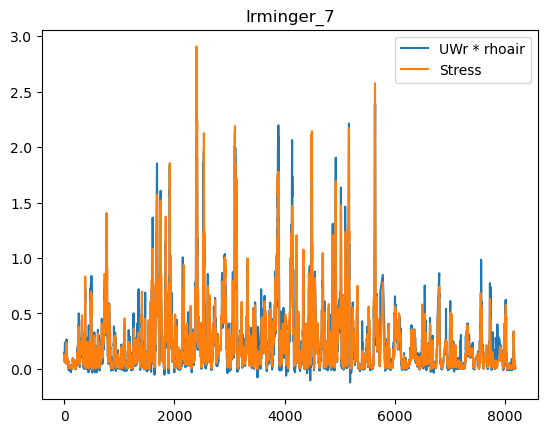

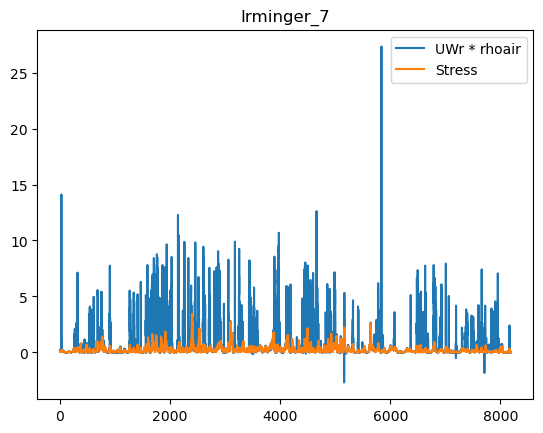

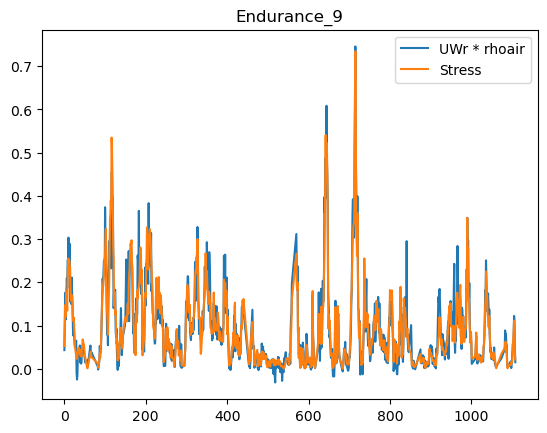

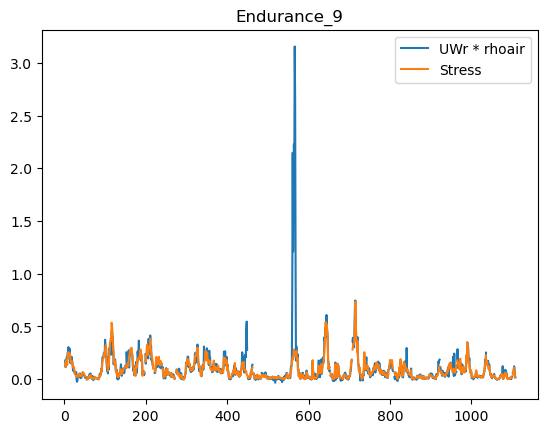

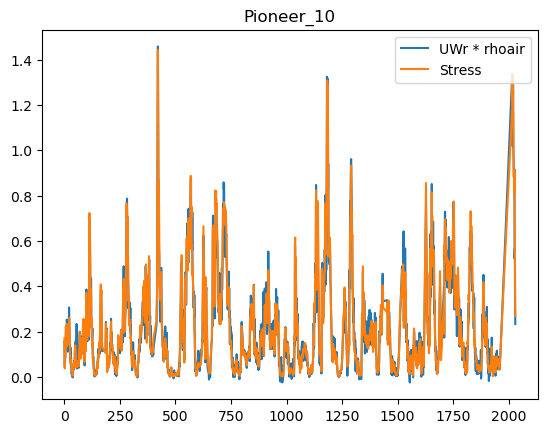

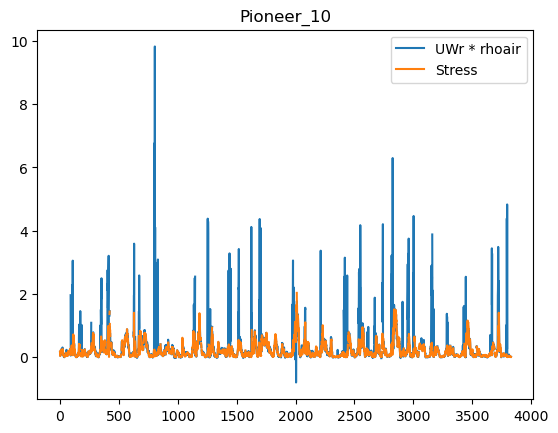

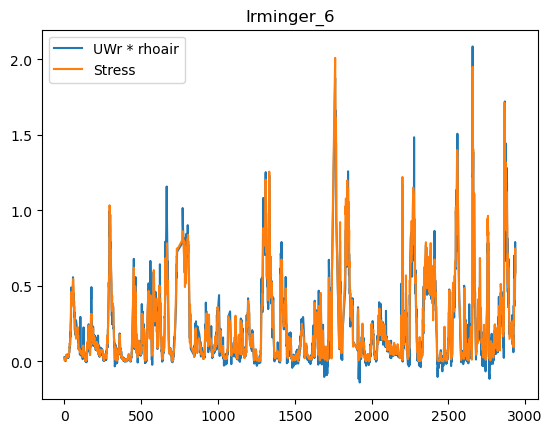

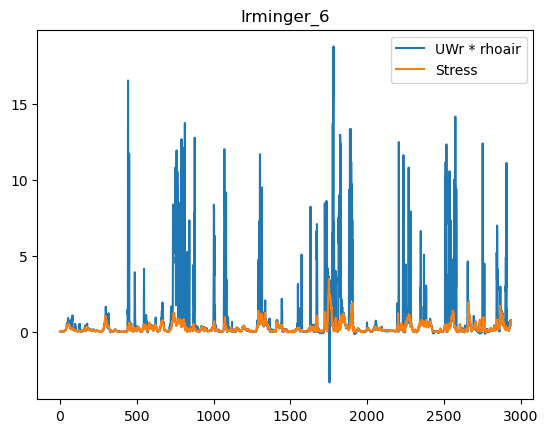

In [11]:
# for each of the datasets, do some data cleanup
# if quality flag entries for which:
# - SBytes != 0
# - any column is inf
# - any column is larger than 1e8
# - any column is close to 9999
# - UW is smaller than some given bounds
# - UW is larger than some given bounds

for crrt_dataset in dict_all_Transfer_files:
    #ic(crrt_dataset)
    time.sleep(0.5)

    crrt_pd = dict_all_Transfer_files[crrt_dataset]

    # valid rows by default
    validity_flag = np.ones((len(crrt_pd.index),), dtype=bool)

    # if find any reason why the row looks bad, invalid it
    for index, row in tqdm.tqdm(crrt_pd.iterrows(), total=len(crrt_pd.index)):

        # NOTE: here are the validity conditions; is it ok to remove the far tails?
        if \
            row["Sbytes"] != 0 or \
            (not np.all(np.isfinite((row[predictors].to_numpy().astype(np.float32))))) or \
            (np.any(row[predictors].to_numpy().astype(np.float32) > 1.0e8)) or \
            (np.any(np.abs(np.real(row[predictors].to_numpy()).astype(np.float32) - 9999.) < 1)) or \
            (row['UW'] < -2.0) or \
            (row['UW'] > 0.2) or \
            (row['UWr'] < -2.0) or \
            (row['UWr'] > 0.2):

            validity_flag[index] = 0

    # add information
    crrt_pd["valid_flag"] = validity_flag
    crrt_pd_valid = crrt_pd.loc[crrt_pd['valid_flag'] == True]
    
    path_strings = str(crrt_dataset).split('.')[0].split('_')
    if path_strings[-1].isnumeric(): 
        buoy = path_strings[-2] + '_' + path_strings[-1]
    else:
        buoy = path_strings[-1]
    print(np.sum(validity_flag), validity_flag.shape)
    plt.figure()
    plt.plot(- crrt_pd_valid['UWr'] * crrt_pd_valid['rhoair'], label='UWr * rhoair')
    plt.plot(crrt_pd_valid['stress'], label='Stress')
    plt.legend()
    plt.title(buoy)
    
    plt.figure()
    plt.plot(- crrt_pd['UWr'] * crrt_pd['rhoair'], label='UWr * rhoair')
    plt.plot(crrt_pd['stress'], label='Stress')
    plt.legend()
    plt.title(buoy)

In [12]:
crrt_dataset

PosixPath('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_Irminger_6.mat')

In [13]:
crrt_pd

,CE,CN,IR,Lv,P10,Pair,Q10,Qair,RH,RH10,...,sigHDir,stress,ustar,yday,yyyy,datetime,lat,lon,datetime_rounded,valid_flag
0,0.058741,0.083610,339.925002,2474.768030,1017.944242,1019.167502,7.248714,7.267303,93.933302,94.014437,...,106.608233,0.023803,0.138781,223.007639,2019,2019-08-11 00:10:59.996491,59.9337,-39.47378,2019-08-11 00:00:00,True
1,0.110629,0.096598,297.949997,2475.081231,1017.797864,1019.020508,7.268667,7.284779,93.525552,93.591409,...,101.552518,0.017449,0.118826,223.049306,2019,2019-08-11 01:10:59.999656,59.9337,-39.47378,2019-08-11 01:00:00,True
2,0.139019,0.126999,348.530000,2475.050118,1017.764995,1018.986008,7.469067,7.480979,93.906953,93.964349,...,98.317455,0.010006,0.089936,223.090972,2019,2019-08-11 02:11:00.000769,59.9337,-39.47378,2019-08-11 02:00:00,True
3,0.187421,0.070342,337.279997,2475.037386,1017.700083,1018.920502,7.588145,7.597242,94.722052,94.793354,...,101.308285,0.006871,0.074493,223.132639,2019,2019-08-11 03:10:59.998945,59.9337,-39.47378,2019-08-11 03:00:00,True
4,0.140239,0.010441,327.305002,2475.172549,1017.320471,1018.540506,7.613828,7.622443,95.132553,95.198827,...,106.933136,0.007151,0.075996,223.174306,2019,2019-08-11 04:10:59.997584,59.9337,-39.47378,2019-08-11 04:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932,0.078067,-0.018678,273.325001,2491.943886,997.514969,998.760501,3.100641,3.165751,80.403552,79.658724,...,204.795173,0.419266,0.576409,387.215972,2020,2020-01-22 05:10:59.952046,59.9337,-39.47378,2020-01-22 05:00:00,True
2933,0.078067,-0.018678,269.544999,2491.941121,997.503489,998.747000,2.916729,2.990077,73.412752,72.353448,...,206.919255,0.409373,0.569918,387.257639,2020,2020-01-22 06:10:59.975539,59.9337,-39.47378,2020-01-22 06:00:00,True
2934,0.078067,-0.018678,282.610001,2491.938347,997.989629,999.240002,3.011154,3.093219,83.999203,82.909322,...,196.948117,0.498005,0.627132,387.299306,2020,2020-01-22 07:11:00.006928,59.9337,-39.47378,2020-01-22 07:00:00,True
2935,0.078067,-0.018678,258.055002,2491.916288,998.007711,999.254504,2.977888,3.049324,78.179452,77.277268,...,209.921894,0.748459,0.769358,387.340972,2020,2020-01-22 08:10:59.967979,59.9337,-39.47378,2020-01-22 08:00:00,True


In [14]:
for c in crrt_pd.columns:
    print(c)

CE
CN
IR
Lv
P10
Pair
Q10
Qair
RH
RH10
SSQ
SST
Sbytes
Solar
T10
Tair
Tm
Tp
Tsea
Tseasonic
Tsonic
U10e
U10r
UE
UEr
UN
UNr
UW
UWr
Ue
Ur
VW
VWr
WT
WTr
Wdir
Wdirr
cp
lhf
moL
mtime
rain
rhoair
shf
sigH
sigHDir
stress
ustar
yday
yyyy
datetime
lat
lon
datetime_rounded
valid_flag


# Get buoy name from the dict keys

In [15]:
d = dict_all_Transfer_files

In [16]:
buoys = []
for key in d.keys():
    path_strings = str(key).split('.')[0].split('_')
    if path_strings[-1].isnumeric(): 
        buoy = path_strings[-2] + '_' + path_strings[-1]
    else:
        buoy = path_strings[-1]
    buoys.append(buoy)
buoys

['Endurance_7',
 'SPURS1',
 'Endurance_3',
 'Pioneer_6',
 'Endurance_8',
 'Pioneer_8',
 'Irminger_3',
 'SPURS2',
 'SouthernOcean2',
 'Pioneer_5',
 'Pioneer_3',
 'Pioneer_7',
 'Endurance_4',
 'CLIMODE',
 'Irminger_7',
 'Endurance_9',
 'Pioneer_10',
 'Irminger_6']

In [17]:
d[key].keys()

Index(['CE', 'CN', 'IR', 'Lv', 'P10', 'Pair', 'Q10', 'Qair', 'RH', 'RH10',
       'SSQ', 'SST', 'Sbytes', 'Solar', 'T10', 'Tair', 'Tm', 'Tp', 'Tsea',
       'Tseasonic', 'Tsonic', 'U10e', 'U10r', 'UE', 'UEr', 'UN', 'UNr', 'UW',
       'UWr', 'Ue', 'Ur', 'VW', 'VWr', 'WT', 'WTr', 'Wdir', 'Wdirr', 'cp',
       'lhf', 'moL', 'mtime', 'rain', 'rhoair', 'shf', 'sigH', 'sigHDir',
       'stress', 'ustar', 'yday', 'yyyy', 'datetime', 'lat', 'lon',
       'datetime_rounded', 'valid_flag'],
      dtype='object')

In [18]:
key

PosixPath('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_Irminger_6.mat')

In [19]:
df_in_situ = d[key]
df_in_situ

,CE,CN,IR,Lv,P10,Pair,Q10,Qair,RH,RH10,...,sigHDir,stress,ustar,yday,yyyy,datetime,lat,lon,datetime_rounded,valid_flag
0,0.058741,0.083610,339.925002,2474.768030,1017.944242,1019.167502,7.248714,7.267303,93.933302,94.014437,...,106.608233,0.023803,0.138781,223.007639,2019,2019-08-11 00:10:59.996491,59.9337,-39.47378,2019-08-11 00:00:00,True
1,0.110629,0.096598,297.949997,2475.081231,1017.797864,1019.020508,7.268667,7.284779,93.525552,93.591409,...,101.552518,0.017449,0.118826,223.049306,2019,2019-08-11 01:10:59.999656,59.9337,-39.47378,2019-08-11 01:00:00,True
2,0.139019,0.126999,348.530000,2475.050118,1017.764995,1018.986008,7.469067,7.480979,93.906953,93.964349,...,98.317455,0.010006,0.089936,223.090972,2019,2019-08-11 02:11:00.000769,59.9337,-39.47378,2019-08-11 02:00:00,True
3,0.187421,0.070342,337.279997,2475.037386,1017.700083,1018.920502,7.588145,7.597242,94.722052,94.793354,...,101.308285,0.006871,0.074493,223.132639,2019,2019-08-11 03:10:59.998945,59.9337,-39.47378,2019-08-11 03:00:00,True
4,0.140239,0.010441,327.305002,2475.172549,1017.320471,1018.540506,7.613828,7.622443,95.132553,95.198827,...,106.933136,0.007151,0.075996,223.174306,2019,2019-08-11 04:10:59.997584,59.9337,-39.47378,2019-08-11 04:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932,0.078067,-0.018678,273.325001,2491.943886,997.514969,998.760501,3.100641,3.165751,80.403552,79.658724,...,204.795173,0.419266,0.576409,387.215972,2020,2020-01-22 05:10:59.952046,59.9337,-39.47378,2020-01-22 05:00:00,True
2933,0.078067,-0.018678,269.544999,2491.941121,997.503489,998.747000,2.916729,2.990077,73.412752,72.353448,...,206.919255,0.409373,0.569918,387.257639,2020,2020-01-22 06:10:59.975539,59.9337,-39.47378,2020-01-22 06:00:00,True
2934,0.078067,-0.018678,282.610001,2491.938347,997.989629,999.240002,3.011154,3.093219,83.999203,82.909322,...,196.948117,0.498005,0.627132,387.299306,2020,2020-01-22 07:11:00.006928,59.9337,-39.47378,2020-01-22 07:00:00,True
2935,0.078067,-0.018678,258.055002,2491.916288,998.007711,999.254504,2.977888,3.049324,78.179452,77.277268,...,209.921894,0.748459,0.769358,387.340972,2020,2020-01-22 08:10:59.967979,59.9337,-39.47378,2020-01-22 08:00:00,True


In [20]:
df_in_situ['datetime'] = pd.to_datetime(df_in_situ['datetime'])
df_in_situ = df_in_situ.set_index('datetime')
df_in_situ

,CE,CN,IR,Lv,P10,Pair,Q10,Qair,RH,RH10,...,sigH,sigHDir,stress,ustar,yday,yyyy,lat,lon,datetime_rounded,valid_flag
datetime,,,,,,,,,,,,,,,,,,,,,
2019-08-11 00:10:59.996491,0.058741,0.083610,339.925002,2474.768030,1017.944242,1019.167502,7.248714,7.267303,93.933302,94.014437,...,1.21,106.608233,0.023803,0.138781,223.007639,2019,59.9337,-39.47378,2019-08-11 00:00:00,True
2019-08-11 01:10:59.999656,0.110629,0.096598,297.949997,2475.081231,1017.797864,1019.020508,7.268667,7.284779,93.525552,93.591409,...,1.06,101.552518,0.017449,0.118826,223.049306,2019,59.9337,-39.47378,2019-08-11 01:00:00,True
2019-08-11 02:11:00.000769,0.139019,0.126999,348.530000,2475.050118,1017.764995,1018.986008,7.469067,7.480979,93.906953,93.964349,...,1.12,98.317455,0.010006,0.089936,223.090972,2019,59.9337,-39.47378,2019-08-11 02:00:00,True
2019-08-11 03:10:59.998945,0.187421,0.070342,337.279997,2475.037386,1017.700083,1018.920502,7.588145,7.597242,94.722052,94.793354,...,1.20,101.308285,0.006871,0.074493,223.132639,2019,59.9337,-39.47378,2019-08-11 03:00:00,True
2019-08-11 04:10:59.997584,0.140239,0.010441,327.305002,2475.172549,1017.320471,1018.540506,7.613828,7.622443,95.132553,95.198827,...,1.02,106.933136,0.007151,0.075996,223.174306,2019,59.9337,-39.47378,2019-08-11 04:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-22 05:10:59.952046,0.078067,-0.018678,273.325001,2491.943886,997.514969,998.760501,3.100641,3.165751,80.403552,79.658724,...,4.88,204.795173,0.419266,0.576409,387.215972,2020,59.9337,-39.47378,2020-01-22 05:00:00,True
2020-01-22 06:10:59.975539,0.078067,-0.018678,269.544999,2491.941121,997.503489,998.747000,2.916729,2.990077,73.412752,72.353448,...,5.03,206.919255,0.409373,0.569918,387.257639,2020,59.9337,-39.47378,2020-01-22 06:00:00,True
2020-01-22 07:11:00.006928,0.078067,-0.018678,282.610001,2491.938347,997.989629,999.240002,3.011154,3.093219,83.999203,82.909322,...,4.80,196.948117,0.498005,0.627132,387.299306,2020,59.9337,-39.47378,2020-01-22 07:00:00,True


In [21]:
df_in_situ.index[0]

Timestamp('2019-08-11 00:10:59.996491')

# ERA5

In [22]:
data_dir_era5 = '/lustre/storeB/project/IT/geout/machine-ocean/data_raw/era5_buoys/'

## Eample

In [23]:
file = 'era_u10m_Irminger_6.nc'
era5 = xr.open_dataset(data_dir_era5 + file)
era5['u10'].sel(
        {
        'time':'2020-01-22 07:11:00.006928', 
        'latitude':59.9337, 
        'longitude':-39.47378
        },
        method='nearest'
        )

<xarray.DataArray 'u10' ()>
array(12.343186, dtype=float32)
Coordinates:
    longitude  float32 -39.47
    latitude   float32 59.93
    time       datetime64[ns] 2020-01-22T07:00:00
Attributes:
    units:      m s**-1
    long_name:  10 metre U wind component

# Import normalized ASCAT metadata dict

In [24]:
data_dir = "/lustre/storeB/project/IT/geout/machine-ocean/data_raw/metop/"

# When running for the first time
with open('../../../in_situ_obs_ascat_with_customisations.pickle', 'rb') as handle:
        ascat_dict = pickle.load(handle)
        
with open(data_dir + 'in_situ_obs_with_ascat_params_9000_images.pickle', 'wb') as handle:
    pickle.dump(ascat_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
with open(data_dir + 'in_situ_obs_with_ascat_params_9000_images.pickle', 'rb') as handle:
    ascat_dict = pickle.load(handle)

In [26]:
ascat_dict.keys()

dict_keys(['Endurance_8', 'Irminger_7', 'SPURS2', 'Endurance_4', 'Irminger_6', 'Pioneer_5', 'CLIMODE', 'Endurance_9', 'Pioneer_10', 'SouthernOcean2', 'Endurance_3', 'Pioneer_3', 'SPURS1', 'Endurance_7', 'Irminger_3', 'Pioneer_7', 'Pioneer_6', 'Pioneer_8'])

In [27]:
ascat_dict['SPURS1'].keys()

dict_keys(['datetime_start', 'datetime_end', 'type', 'lat', 'lon', 'nc_data_location', 'products', 'nc_files', 'ascat_params'])

In [28]:
ascat_dict['Pioneer_3']['nc_files']['ASCA_SZR_1B_M01_20151023010000Z_20151023024158Z_N_O_20151023014637Z']

'ASCATL1SZR_20151023T010000Z_20151023T024158Z_epct_d458fe47_P.nc'

In [29]:
ascat_dict['Pioneer_3']['ascat_params']

{'ASCA_SZR_1B_M01_20151023010000Z_20151023024158Z_N_O_20151023014637Z': {'grid_lats_orig': array([ 89.04860631,  88.68158249,  88.31455867,  87.94753484,
          87.58051102,  87.21348719,  86.84646337,  86.47943954,
          86.11241572,  85.7453919 ,  85.37836807,  85.01134425,
          84.64432042,  84.2772966 ,  83.91027278,  83.54324895,
          83.17622513,  82.8092013 ,  82.44217748,  82.07515366,
          81.70812983,  81.34110601,  80.97408218,  80.60705836,
          80.24003454,  79.87301071,  79.50598689,  79.13896306,
          78.77193924,  78.40491542,  78.03789159,  77.67086777,
          77.30384394,  76.93682012,  76.5697963 ,  76.20277247,
          75.83574865,  75.46872482,  75.101701  ,  74.73467718,
          74.36765335,  74.00062953,  73.6336057 ,  73.26658188,
          72.89955806,  72.53253423,  72.16551041,  71.79848658,
          71.43146276,  71.06443894,  70.69741511,  70.33039129,
          69.96336746,  69.59634364,  69.22931982,  68.86229599,
 

In [51]:
ascat_dict['Pioneer_3']['lat']

[40.1334]

In [52]:
ascat_dict['Irminger_3']['products']

<class 'eumdac.collection.SearchResults'>(EO:EUM:DAT:METOP:ASCSZR1B, {'publication': None, 'dtstart': '2016-07-10T12:11:00.011105+00:00', 'set': None, 'bbox': None, 'orbit': None, 'type': None, 'sat': None, 'sort': None, 'title': None, 't6': None, 'geo': 'POINT(-39.4738 59.9337)', 'dtend': '2017-08-14T01:11:59.949652+00:00', 'zone': None})

In [53]:
for product, fname in ascat_dict['Pioneer_3']['nc_files'].items():
    print(fname)

ASCATL1SZR_20151023T010000Z_20151023T024158Z_epct_d458fe47_P.nc
ASCATL1SZR_20151022T145100Z_20151022T163258Z_epct_d55bf5b6_P.nc
ASCATL1SZR_20151022T135700Z_20151022T153558Z_epct_82855dc8_P.nc
ASCATL1SZR_20151021T233600Z_20151022T012058Z_epct_f94cadfe_P.nc
ASCATL1SZR_20151021T151200Z_20151021T165058Z_epct_42b5f330_P.nc
ASCATL1SZR_20151021T004500Z_20151021T022658Z_epct_891fb4fe_P.nc
ASCATL1SZR_20151021T000000Z_20151021T014158Z_epct_8b2bcdcc_P.nc
ASCATL1SZR_20151020T135400Z_20151020T153258Z_epct_57f6ecb6_P.nc
ASCATL1SZR_20151019T150000Z_20151019T163858Z_epct_fbc8cd2e_P.nc
ASCATL1SZR_20151019T141500Z_20151019T155358Z_epct_709cee11_P.nc
ASCATL1SZR_20151019T004200Z_20151019T022358Z_epct_eefbf552_P.nc
ASCATL1SZR_20151018T234500Z_20151019T012658Z_epct_958c3d38_P.nc
ASCATL1SZR_20151018T010300Z_20151018T024458Z_epct_feeb1040_P.nc
ASCATL1SZR_20151017T145400Z_20151017T163558Z_epct_0f085316_P.nc
ASCATL1SZR_20151017T140000Z_20151017T153858Z_epct_e954376f_P.nc
ASCATL1SZR_20151016T234200Z_20151017T012

# Fill in ASCAT dict with params

In [54]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
count = 0
for buoy in ascat_dict.keys():
    station_lat = ascat_dict[buoy]['lat'][0]
    station_lon = ascat_dict[buoy]['lon'][0]
    print(buoy)
    if 'ascat_params' not in ascat_dict[buoy].keys():
                ascat_dict[buoy]['ascat_params'] = {}
            
    if 'nc_files' in ascat_dict[buoy].keys():
        for product, fname in ascat_dict[buoy]['nc_files'].items():
                try:
                    ascat_param_dict = ascat.ascat_params(
                        ascat_fn = data_dir + fname,
                        station_lon=station_lon,
                        station_lat=station_lat,
                    )
                    ascat_dict[buoy]['ascat_params'][product] = ascat_param_dict
                except:
                    print('Data from buoy ', buoy, 'File ', fname, ' cannot be extracted. ') # Check if the image exists and if the crop area is within the image
                    count = count - 1                 
                
print('Number of images that were not cropped: ', count)

Endurance_8
Irminger_7
Data from buoy  Irminger_7 File  ASCATL1SZR_20201004T133600Z_20201004T151458Z_epct_1c1c4cb2_P.nc  cannot be extracted. 


In [ ]:
ascat_dict['Pioneer_5']['nc_files']['ASCA_SZR_1B_M02_20161015150900Z_20161015165058Z_N_O_20161015164912Z']

In [ ]:
ascat_dict['Pioneer_5']['ascat_params']['ASCA_SZR_1B_M02_20161015150900Z_20161015165058Z_N_O_20161015164912Z']

with open(data_dir + 'in_situ_obs_with_ascat_params_9000_images.pickle', 'wb') as handle:
    pickle.dump(ascat_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Merge in situ obs and ASCAT data

empty dict for new dfs

For each key in d:

    get buoy name
    get df for that buoy
    add empty cols for s0, inc, az
    for each product
        find closest timestamp in df to (beginposition+(endposition-startposition))/2
        fill in that row with sar params
    remove rows with nans
    save df with matches in new dict



    df['sigma0_trip_fore'] = np.nan
    df['sigma0_trip_mid'] = np.nan
    df['sigma0_trip_aft'] = np.nan
    df['azi_angle_trip_fore'] = np.nan
    df['azi_angle_trip_mid'] = np.nan
    df['azi_angle_trip_aft'] = np.nan
    df['inc_angle_trip_fore'] = np.nan 
    df['inc_angle_trip_mid'] = np.nan 
    df['inc_angle_trip_aft'] = np.nan
    

In [27]:
df_in_situ = d[Path('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_Pioneer_5.mat')]
df_in_situ = df_in_situ.loc[df_in_situ['valid_flag'] == True]
df_in_situ['datetime'] = pd.to_datetime(df_in_situ['datetime'])
df_in_situ = df_in_situ.set_index('datetime')

In [28]:
list_of_params = [
        'sigma0_trip_fore', 'sigma0_trip_mid', 'sigma0_trip_aft',
        'azi_angle_trip_fore', 'azi_angle_trip_mid', 'azi_angle_trip_aft',
        'inc_angle_trip_fore', 'inc_angle_trip_mid', 'inc_angle_trip_aft',
        'start_sensing_time',
        'stop_sensing_time'
    ]

In [29]:
count = 0
collocated_dict = {}
for key, df in d.items(): # One dict per buoy
    buoy = buoys[count]
    
    if buoy != 'SPURS1':
        print(buoy)
        # Load in situ data
        df_in_situ = d[key]
        df_in_situ = df_in_situ.loc[df_in_situ['valid_flag'] == True]
        df_in_situ['datetime'] = pd.to_datetime(df_in_situ['datetime'])
        df_in_situ = df_in_situ.set_index('datetime')

        # Load ERA5 data
        u_file = 'era_u10m_' + buoy + '.nc'
        v_file = 'era_v10m_' + buoy + '.nc'
        u10_dataset = xr.open_dataset(data_dir_era5 + u_file)
        v10_dataset = xr.open_dataset(data_dir_era5 + v_file)

        for parameter in (list_of_params + ['u10', 'v10']):
            df_in_situ[parameter] = np.nan

        for product in ascat_dict[buoy]['ascat_params']:
            beginposition = ascat_dict[buoy]['ascat_params'][product]['start_sensing_time']        
            beginposition = beginposition.replace('Z', '.')
            beginposition = datetime.strptime(beginposition.split('.')[0],'%Y%m%dT%H%M%S')  

            endposition = ascat_dict[buoy]['ascat_params'][product]['stop_sensing_time']
            endposition = endposition.replace('Z', '.')
            endposition = datetime.strptime(endposition.split('.')[0],'%Y%m%dT%H%M%S')  

            # TODO:
            # We need to get all the observations between start - 30 min <= date <= end + 30 min
            #greater than the start date and smaller than the end date
            mask = (df_in_situ.index > beginposition - timedelta(minutes=20)) & (df_in_situ.index <= endposition + timedelta(minutes=20))
            df_begin_end = df_in_situ.loc[mask]
            timestamps = df_begin_end.index

            for parameter in list_of_params:
                # Fill in with ASCAT params
                for timestamp in timestamps:
                    df_in_situ.loc[df_in_situ.index==timestamp, parameter] = ascat_dict[buoy]['ascat_params'][product][parameter]

            # Fill in with ERA5 data
            for timestamp in timestamps:
                df_in_situ.loc[df_in_situ.index==timestamp, 'u10']  = u10_dataset['u10'].sel(
                    {
                    'time':timestamp, 
                    'latitude':df_in_situ['lat'][0], 
                    'longitude':df_in_situ['lon'][0]
                    },
                    method='nearest'
                    ).values
                # Fill in with ERA5 data
                df_in_situ.loc[df_in_situ.index==timestamp, 'v10'] = v10_dataset['v10'].sel(
                    {
                    'time':timestamp, 
                    'latitude':df_in_situ['lat'][0], 
                    'longitude':df_in_situ['lon'][0]
                    },
                    method='nearest'
                    ).values

        df_in_situ = df_in_situ.replace([-np.inf], np.nan)
        df_in_situ = df_in_situ.dropna(subset=['sigma0_trip_fore', 'sigma0_trip_mid', 'sigma0_trip_aft'])
        collocated_dict[buoy] = df_in_situ
    else:
        print('We do not include ', buoy)
    count = count + 1

Endurance_7
We do not include  SPURS1
Endurance_3
Pioneer_6
Endurance_8
Pioneer_8
Irminger_3
SPURS2
SouthernOcean2
Pioneer_5
Pioneer_3
Pioneer_7
Endurance_4
CLIMODE
Irminger_7
Endurance_9
Pioneer_10
Irminger_6


In [30]:
collocated_dict[buoy]

,CE,CN,IR,Lv,P10,Pair,Q10,Qair,RH,RH10,...,azi_angle_trip_fore,azi_angle_trip_mid,azi_angle_trip_aft,inc_angle_trip_fore,inc_angle_trip_mid,inc_angle_trip_aft,start_sensing_time,stop_sensing_time,u10,v10
datetime,,,,,,,,,,,,,,,,,,,,,
2019-08-11 13:10:59.996759,0.178938,0.101390,341.660002,2474.809122,1017.426988,1018.645490,7.585522,7.604719,92.496903,92.327994,...,56.430000,102.079994,147.610001,43.239998,32.899998,43.219997,20190811T123300Z,20190811T141158.125000Z,-5.115729,-0.091023
2019-08-11 14:10:59.996021,0.183869,0.075291,342.504999,2474.597208,1017.185669,1018.404016,7.615780,7.633561,93.048452,92.957714,...,56.430000,102.079994,147.610001,43.239998,32.899998,43.219997,20190811T123300Z,20190811T141158.125000Z,-5.000642,0.290524
2019-08-11 15:10:59.997899,0.140371,0.029420,343.119998,2474.740347,1017.022296,1018.240500,7.521966,7.544814,91.938303,91.756495,...,-19.100000,-63.840000,-108.930000,38.590000,29.090000,38.829998,20190811T133900Z,20190811T151758.125000Z,-4.859635,0.531045
2019-08-11 21:10:59.996822,0.026891,-0.036313,341.965004,2474.961256,1016.163365,1017.380988,7.488089,7.510747,92.048802,91.869156,...,106.750000,62.049999,17.449999,47.070000,36.469997,46.950001,20190811T205400Z,20190811T223558.125000Z,-4.402400,0.030968
2019-08-11 22:11:00.000058,0.051789,-0.020034,340.510001,2475.074551,1016.204222,1017.421991,7.507270,7.527613,92.414853,92.252491,...,106.750000,62.049999,17.449999,47.070000,36.469997,46.950001,20190811T205400Z,20190811T223558.125000Z,-4.639831,-0.068528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-21 15:10:59.980900,0.078067,-0.018678,286.894995,2491.681647,996.236889,997.464505,4.346215,4.374028,86.797202,86.444072,...,-13.349999,-57.930000,-102.669998,58.980000,47.930000,59.090000,20200121T132400Z,20200121T150558.125000Z,1.486705,11.194453
2020-01-21 20:10:59.965464,0.078067,-0.018678,303.655000,2491.649560,994.401416,995.630505,4.236066,4.264247,89.521652,89.357990,...,105.129997,60.469997,15.740000,52.669998,41.669998,52.629997,20200121T200600Z,20200121T214758.125000Z,4.111918,8.730406
2020-01-21 21:10:59.980005,0.078067,-0.018678,281.330002,2491.649510,994.284652,995.514005,4.237512,4.264786,90.106352,89.978233,...,105.129997,60.469997,15.740000,52.669998,41.669998,52.629997,20200121T200600Z,20200121T214758.125000Z,5.371648,8.590245


In [31]:
collocated_dict['Pioneer_7'][['UWr', 'rhoair', 'sigma0_trip_fore', 'u10', 'v10']]

,UWr,rhoair,sigma0_trip_fore,u10,v10
datetime,,,,,
2017-06-09 15:11:00.013167,-0.108552,1.213399,-23.606268,8.010499,-1.526693
2017-06-09 16:11:00.017771,-0.149502,1.213591,-23.606268,8.365516,0.692515
2017-06-10 14:11:00.033378,-0.013028,1.219626,-27.670694,5.165925,1.848096
2017-06-10 15:11:00.035909,-0.019739,1.220326,-27.670694,5.109122,2.156188
2017-06-11 01:12:00.010394,-0.051168,1.210728,-23.581158,5.572419,5.996433
...,...,...,...,...,...
2017-10-28 15:12:00.010730,-0.017372,1.214561,-26.016972,1.396531,4.167790
2017-10-28 16:12:00.028720,-0.013269,1.212989,-19.373363,1.195946,4.595327
2017-10-29 01:11:59.980169,-0.118747,1.204730,-24.191271,-2.139438,7.332129


In [32]:
collocated_dict['Irminger_3'][['UWr', 'rhoair', 'sigma0_trip_fore', 'u10', 'v10']]

,UWr,rhoair,sigma0_trip_fore,u10,v10
datetime,,,,,
2016-07-10 22:11:00.002925,-0.016792,1.256439,-27.038279,-2.566202,1.626370
2016-07-10 23:11:00.012195,-0.023148,1.256706,-27.038279,-2.596270,1.365084
2016-07-11 12:10:59.985949,-0.008453,1.258117,-26.535995,-2.105857,0.999975
2016-07-11 13:11:00.003236,-0.007296,1.257028,-26.535995,-1.809328,1.005167
2016-07-11 14:10:59.983016,-0.003911,1.255727,-26.535995,-1.701499,0.840781
...,...,...,...,...,...
2017-08-11 23:11:59.980186,-0.061721,1.245206,-30.524120,-0.500868,5.510186
2017-08-12 00:11:59.981048,-0.026354,1.245716,-30.524120,-0.324610,5.441836
2017-08-12 12:11:59.989959,-0.001817,1.241915,-31.923285,-0.985061,-1.199325


with open(data_dir + 'collocated_dict_ascat_9000_images_era5_without_spurs1.pickle', 'wb') as handle:
    pickle.dump(collocated_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)